In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
plt.rcParams["figure.figsize"] = [6,6]

In [337]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        self.timestep = 0
        self.done = False
        
        self.pos = {'knight':[3,0],
                   'mon1':[1,2],
                   'mon2':[2,1],
                   'chest':[0,3],
                   'coin1':[3,1],
                   'coin2':[1,3]}
        
        self.mon1_death = False
        self.mon2_death = False
        self.coin1_collected = False
        self.coin2_collected = False
        
        # loading assets for rendering
        
        chars = mpimg.imread('Dungeon_Character.png')
        tiles = mpimg.imread('Dungeon_Tileset.png')
        assets = {}
        assets['knight'] = chars[:16,16*5:16*6]
        assets['mon1'] = chars[16:,16*6:]
        assets['mon2'] = chars[16:,16*5:16*6]
        assets['chest'] = tiles[16*8:16*9,16*4:16*5]
        assets['bones'] = tiles[16*7:16*8,16*7:16*8]
        torch = tiles[16*9:,:16]
        assets['coin1'] = tiles[16*8:16*9,16*6:16*7]
        assets['coin2'] = assets['coin1']
        stage = np.concatenate((tiles[:16*3,:16*6],
                                np.flip(tiles[16*2:16*3,:16*6],axis=1),
                                tiles[16*3:16*5,:16*6]),axis=0)
        stage[:16,16:16*2] = np.where(torch != 0,torch,stage[:16,16:16*2])
        stage[:16,16*4:16*5] = np.where(torch != 0,torch,stage[:16,16*4:16*5])
        self.stage = stage
        self.assets = assets
        self.archives = [tuple(self.pos['knight']+[self.mon1_death,self.mon2_death,self.coin1_collected,self.coin2_collected])]
        
    def archive(self):
        instance = tuple(self.pos['knight']+[self.mon1_death,self.mon2_death,self.coin1_collected,self.coin2_collected])
        self.archives.append(instance)

    def reset(self):
        self.timestep = 0
        self.pos = {'knight':[3,0],
                   'mon1':[1,2],
                   'mon2':[2,1],
                   'chest':[0,3],
                   'coin1':[3,1],
                   'coin2':[1,3]}
        
        self.mon1_death = False
        self.mon2_death = False
        self.coin1_collected = False
        self.coin2_collected = False
        
        self.archives = [tuple(self.pos['knight']+[self.mon1_death,self.mon2_death,self.coin1_collected,self.coin2_collected])]
        self.done = False
        
        return self.pos['knight'][0]*4 + self.pos['knight'][1]
    
    def step(self, action, stochastic = False):
        '''
        0 - up
        1 - down
        2 - right
        3 - left
        '''
        if stochastic == True:
            action_prop = 0.6
            props = [0.1,0.1,0.1,0.1]
            props[action] += 0.6
            action = np.random.choice(4, 1, p=props)[0]
            
        if action == 0:
            self.pos['knight'][0] += 1
        elif action == 1:
            self.pos['knight'][0] -= 1
        elif action == 2:
            self.pos['knight'][1] += 1
        elif action == 3:
            self.pos['knight'][1] -= 1

        self.pos['knight'] = list(np.clip(self.pos['knight'], 0, 3))
        self.archive()
        
        reward = 0
        if self.pos['knight'] == self.pos['chest']:
            reward = 10
            self.done = True
            
        elif self.pos['knight'] == self.pos['mon1']:
            if self.mon1_death:
                pass
            else:
                reward = -10
                self.mon1_death = True
                
        elif self.pos['knight'] == self.pos['mon2']:
            if self.mon2_death:
                pass
            else:
                reward = -10
                self.mon2_death = True
        elif self.pos['knight'] == self.pos['coin1']:
            if self.coin1_collected:
                pass
            else:
                reward = 2
                self.coin1_collected = True
        elif self.pos['knight'] == self.pos['coin2']:
            if self.coin2_collected:
                pass
            else:
                reward = 2
                self.coin2_collected = True
        
        self.timestep += 1
        if self.timestep == self.max_timesteps:
            self.done = True
        
        return self.pos['knight'][0]*4 + self.pos['knight'][1], reward
    
    def project(self,archive_pos):
        instance = np.copy(self.stage)
        for item in ['mon1','mon2','chest','coin1','coin2']:
            item_asset = item
            if item == 'mon1' and archive_pos[2]:
                item_asset = 'bones'
            elif item == 'mon2' and archive_pos[3]:
                item_asset = 'bones'
            elif item == 'coin1' and archive_pos[4]:
                continue
            elif item == 'coin2' and archive_pos[5]:
                continue
            x = np.where(self.assets[item_asset] != 0, self.assets[item_asset], 
                       instance[16*(self.pos[item][0]+1):16*(self.pos[item][0]+2),
                                16*(self.pos[item][1]+1):16*(self.pos[item][1]+2)])
            instance[16*(self.pos[item][0]+1):16*(self.pos[item][0]+2),
                     16*(self.pos[item][1]+1):16*(self.pos[item][1]+2)] = x
            
        x = np.where(self.assets['knight'] != 0, self.assets['knight'], 
                    instance[16*(archive_pos[0]+1):16*(archive_pos[0]+2),
                            16*(archive_pos[1]+1):16*(archive_pos[1]+2)])
        instance[16*(archive_pos[0]+1):16*(archive_pos[0]+2),
                    16*(archive_pos[1]+1):16*(archive_pos[1]+2)] = x
        return instance
    
    def render(self):
        for instance in self.archives:
            instance = self.project(instance)
            plt.figure()
            plt.axis('off')
            plt.imshow(instance,interpolation='none',aspect='equal')
        

In [394]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def step(self, pos):
        return np.random.choice(self.action_space.n)

class Qlearning:
    def __init__(self,env):
        self.env = env
        self.observation_space = env.observation_space.n
        self.action_space = env.action_space.n
        self.table = np.zeros((self.observation_space,self.action_space))
        self.rewards = []
        
    def step(self,state,er):
        x = np.random.choice(2,1,p=[er,1-er])[0]
        # print(x)
        if x:
            action = np.argmax(self.table[state,:])
        else:
            action = self.env.action_space.sample()
        
        return action
    
    def train(self,num_epochs,lr,df,er,min_er,edr):
        '''
        lr     |  learning rate
        df     |  discount factor
        er     |  xploration rate
        min_er |  min exploration rate
        edr    |  exploration decay rate
        '''
        for epoch in range(num_epochs):
            state = self.env.reset()
            total_reward = 0.0
            while not self.env.done:
                action = self.step(state,er)
                new_state, reward = self.env.step(action)
                self.table[state,action] = (1 - lr) * self.table[state,action] + \
                                            lr * (reward + df * np.max(agent.table[new_state,:]))
                state = new_state
                total_reward += reward
            self.rewards.append(total_reward)
            er = min_er + (1 - min_er) * np.exp(-edr*epoch)
            
    def running_mean(self,x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)
            
    def stats(self,interval):
        avg_rewards = self.running_mean(self.rewards,interval)
        print(len(avg_rewards))
        plt.plot(avg_rewards)
        plt.show()

In [413]:
agent = Qlearning(GridEnvironment())

In [414]:
agent.train(10000,0.1,0.7,1,0.01,0.001)

9901


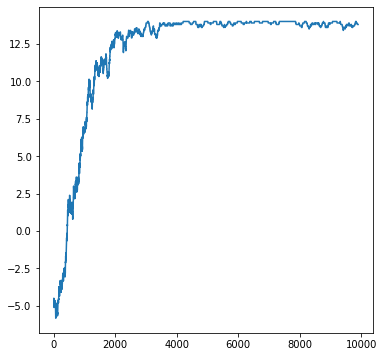

In [417]:
agent.stats(100)

In [418]:
agent.table

array([[ 0.59202696,  0.26888721,  2.97268643,  0.41508042],
       [ 1.1418379 ,  1.80248822,  6.7624628 ,  0.68937769],
       [-1.50097683,  4.32612878,  9.94273583,  1.89868489],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.84421889,  1.01192817,  1.37456593,  0.7308389 ],
       [-2.16147997,  4.53180641, -4.76389086,  0.81158855],
       [ 4.09838351,  5.76268084,  7.82235397,  2.68873982],
       [ 6.29749304, 10.        ,  6.99999997, -4.59010473],
       [ 2.90707958,  1.16417927, -4.93594635,  1.84803565],
       [ 2.14829214,  2.67049493,  4.40839465,  1.89981669],
       [ 3.0819977 , -4.6388152 ,  6.29999997, -6.85374141],
       [ 4.39189555,  9.        ,  6.2960465 ,  4.40420083],
       [ 2.90526625,  2.02955779,  4.15761224,  2.90721896],
       [ 2.15674402, -6.87964045,  3.08699901,  2.9048711 ],
       [ 3.08335184,  4.40999977,  4.38198604,  2.15842191],
       [ 4.38460108,  6.26278279,  4.39003752,  3.07478231]])